In [4]:

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


In [5]:
DATA_FILES = {
    "p1_gen": "Plant_1_Generation_Data.csv",
    "p1_wx":  "Plant_1_Weather_Sensor_Data.csv",
    "p2_gen": "Plant_2_Generation_Data.csv",
    "p2_wx":  "Plant_2_Weather_Sensor_Data.csv",
}

ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [6]:
def load_and_merge(gen_path: str, wx_path: str) -> pd.DataFrame:

    gen = pd.read_csv(gen_path)
    wx  = pd.read_csv(wx_path) 

    gen["DATE_TIME"] = pd.to_datetime(gen["DATE_TIME"], errors="coerce")
    wx["DATE_TIME"]  = pd.to_datetime(wx["DATE_TIME"],  errors="coerce")

    wx_keep = ["PLANT_ID", "DATE_TIME", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]
    wx = wx[wx_keep]

    df = pd.merge(gen, wx, on=["PLANT_ID", "DATE_TIME"], how="left")

    return df


In [7]:
print("Loading & merging...")
plant1 = load_and_merge(DATA_FILES["p1_gen"], DATA_FILES["p1_wx"])            
plant2 = load_and_merge(DATA_FILES["p2_gen"], DATA_FILES["p2_wx"])            


Loading & merging...


In [8]:
raw = pd.concat([plant1, plant2], ignore_index=True)
raw = raw.sort_values(["SOURCE_KEY", "DATE_TIME"]).reset_index(drop=True)
print(f"Combined shape: {raw.shape}")

Combined shape: (136476, 10)


In [9]:
print("First 5 rows:")
display(raw.head())

print("Last 5 rows:")
display(raw.tail())

print(f"Dataset shape: {raw.shape}")

print("\nColumn names:")
print(list(raw.columns))

print("\nData info:")
raw.info()

print("\nStatistical summary:")
display(raw.describe())


First 5 rows:


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,24.621525,22.165423,0.0


Last 5 rows:


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
136471,2020-06-17 22:45:00,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,22.150570,21.480377,0.0
136472,2020-06-17 23:00:00,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,22.129816,21.389024,0.0
136473,2020-06-17 23:15:00,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,22.008275,20.709211,0.0
136474,2020-06-17 23:30:00,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,21.969495,20.734963,0.0
136475,2020-06-17 23:45:00,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,21.909288,20.427972,0.0


Dataset shape: (136476, 10)

Column names:
['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136476 entries, 0 to 136475
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DATE_TIME            136476 non-null  datetime64[ns]
 1   PLANT_ID             136476 non-null  int64         
 2   SOURCE_KEY           136476 non-null  object        
 3   DC_POWER             136476 non-null  float64       
 4   AC_POWER             136476 non-null  float64       
 5   DAILY_YIELD          136476 non-null  float64       
 6   TOTAL_YIELD          136476 non-null  float64       
 7   AMBIENT_TEMPERATURE  136472 non-null  float64       
 8   MODULE_TEMPERATURE   136472 non-null  float64       
 9   IRRADIATION          136472 non-null 

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,136476,1.364760e+05,136476.000000,136476.000000,136476.000000,1.364760e+05,136472.000000,136472.000000,136472.000000
mean,2020-06-01 09:23:03.157477888,4.135497e+06,1708.541497,274.803511,3295.433783,3.303821e+08,26.763066,31.920744,0.230767
min,2020-05-15 00:00:00,4.135001e+06,0.000000,0.000000,0.000000,0.000000e+00,20.398505,18.140415,0.000000
25%,2020-05-23 23:00:00,4.135001e+06,0.000000,0.000000,28.321429,6.520020e+06,23.637604,22.411698,0.000000
50%,2020-06-01 18:45:00,4.135001e+06,6.050000,3.506905,2834.803572,7.269333e+06,25.908122,26.413755,0.026213
75%,2020-06-09 21:45:00,4.136001e+06,1155.788333,532.673333,5992.000000,2.826096e+08,29.266583,40.778583,0.442961
max,2020-06-17 23:45:00,4.136001e+06,14471.125000,1410.950000,9873.000000,2.247916e+09,39.181638,66.635953,1.221652
std,NaN,4.999862e+02,3222.181273,380.182569,3035.294425,6.085705e+08,3.897340,11.803674,0.305652


In [10]:
missing_summary = raw.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]  

if missing_summary.empty:
    print("No missing values found in the dataset.")
else:
    print("Missing values detected:")
    print(missing_summary)


Missing values detected:
AMBIENT_TEMPERATURE    4
MODULE_TEMPERATURE     4
IRRADIATION            4
dtype: int64


In [11]:
# Forward-fill missing values
raw = raw.fillna(method="ffill")

# Check any missing values 
print("Missing values after forward fill:")
print(raw.isnull().sum())

Missing values after forward fill:
DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


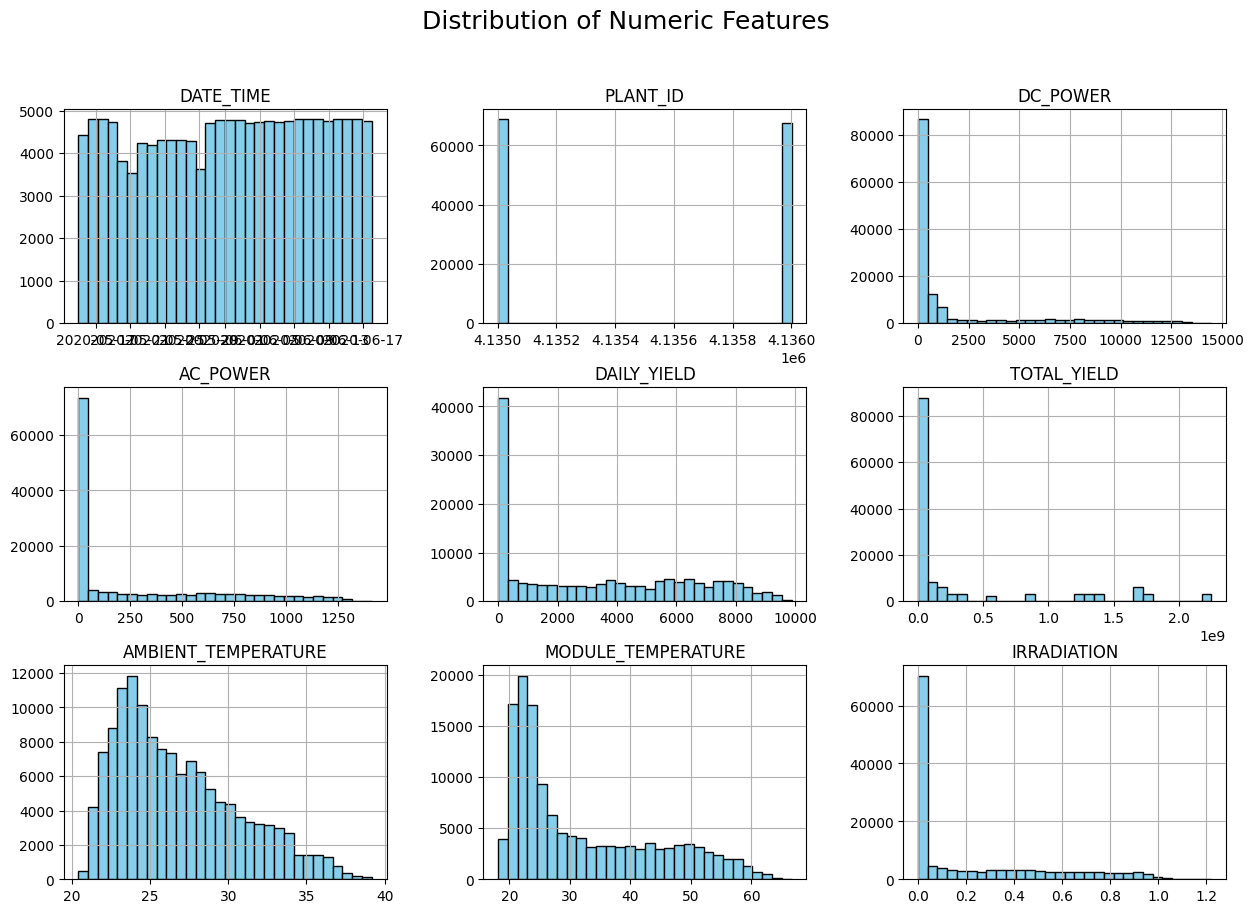

In [12]:
raw.hist(figsize=(15,10), bins=30, color="skyblue", edgecolor="black")
plt.suptitle("Distribution of Numeric Features", fontsize=18)
plt.show()

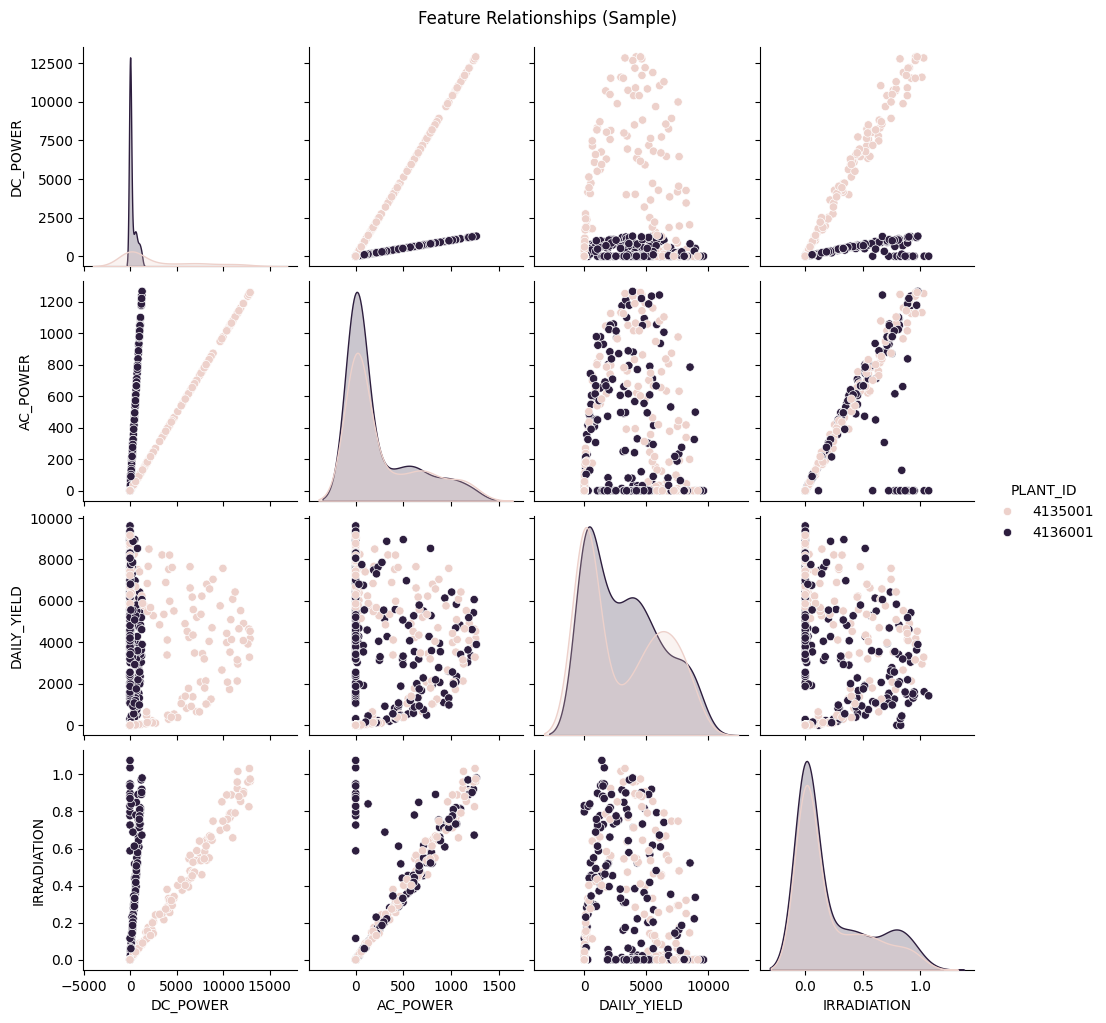

In [13]:

sns.pairplot(raw.sample(500), vars=["DC_POWER", "AC_POWER", "DAILY_YIELD", "IRRADIATION"], hue="PLANT_ID")
plt.suptitle("Feature Relationships (Sample)", y=1.02)
plt.show()


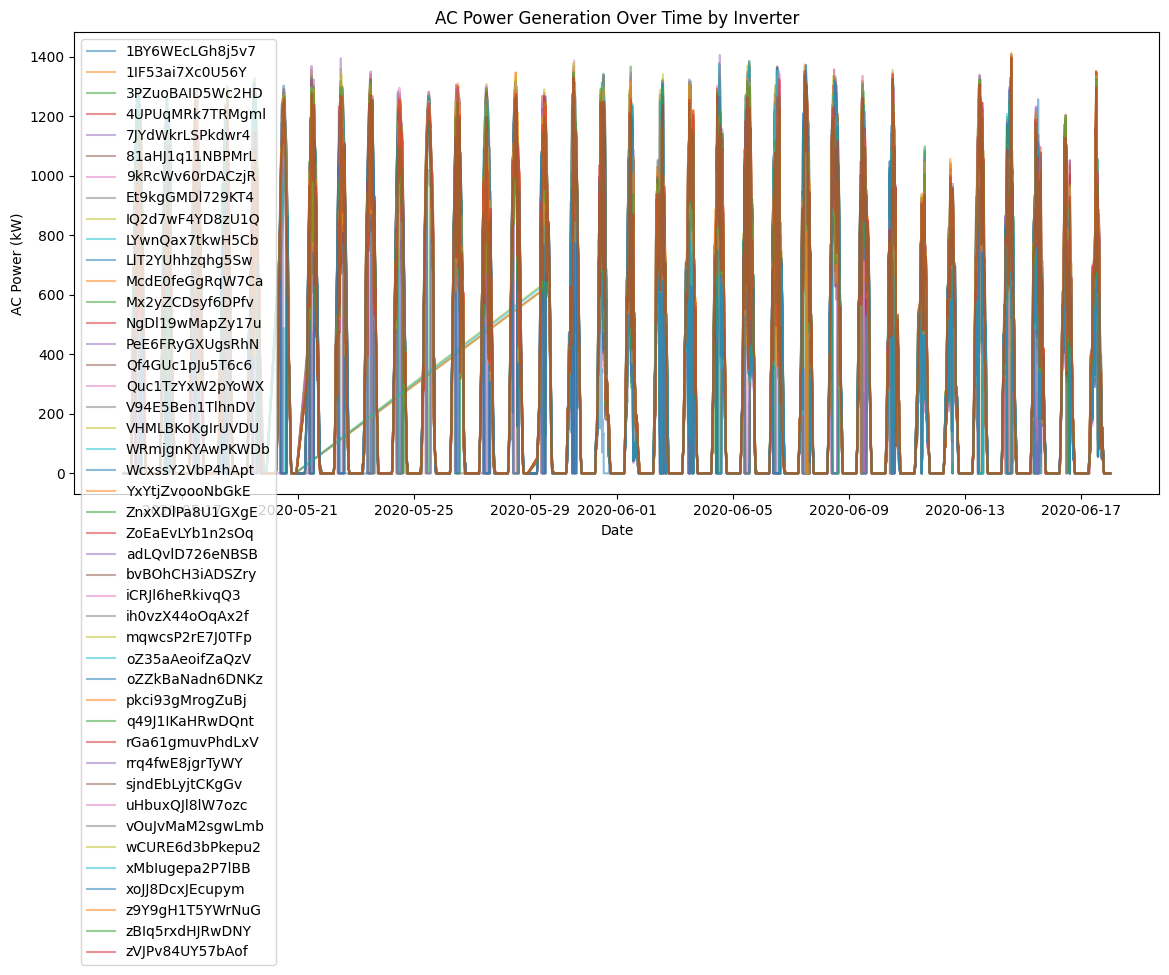

In [ ]:
plt.figure(figsize=(14,6))
for key, group in raw.groupby("SOURCE_KEY"):
    plt.plot(group["DATE_TIME"], group["AC_POWER"], label=key, alpha=0.5)
plt.xlabel("Date")
plt.ylabel("AC Power (kW)")
plt.title("AC Power Generation Over Time by Inverter")
plt.legend()
plt.show()


In [15]:


def make_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Extract hour of day & date from timestamp
    df["HOUR"] = df["DATE_TIME"].dt.hour
    df["DATE"] = df["DATE_TIME"].dt.date

    # Rolling statistics per inverter (SOURCE_KEY). Assuming 15-min sampling rate.
    df["DC_POWER_ROLLING_MEAN_1H"] = (
        df.groupby("SOURCE_KEY")["DC_POWER"].transform(lambda x: x.rolling(4, min_periods=1).mean())
    )
    df["DC_POWER_ROLLING_STD_1H"] = (
        df.groupby("SOURCE_KEY")["DC_POWER"].transform(lambda x: x.rolling(4, min_periods=1).std())
    )
    df["IRRADIATION_ROLLING_MAX_3H"] = (
        df.groupby("SOURCE_KEY")["IRRADIATION"].transform(lambda x: x.rolling(12, min_periods=1).max())
    )

    # Lag features (previous interval values)
    df["DC_POWER_LAG_1"] = df.groupby("SOURCE_KEY")["DC_POWER"].shift(1)
    df["IRRADIATION_LAG_1"] = df.groupby("SOURCE_KEY")["IRRADIATION"].shift(1)

    # Daily cumulative yield (resets per inverter each day)
    df["DAILY_YIELD_CUMSUM"] = df.groupby(["SOURCE_KEY", "DATE"])['DAILY_YIELD'].cumsum()

    # Interaction term + efficiency metric
    df["IRRADIATION_x_AMBIENT_TEMP"] = df["IRRADIATION"] * df["AMBIENT_TEMPERATURE"]
    eps = 1e-6
    df["EFFICIENCY"] = df["DC_POWER"] / (df["IRRADIATION"] + eps)

    return df


In [16]:
# Apply the feature creation to cleaned dataset
feat_df = make_features(raw)


In [17]:
# Check for missing values in all columns (after feature engineering)
missing_counts = feat_df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

if not missing_counts.empty:
    print("Missing values detected:")
    print(missing_counts)
else:
    print("No missing values detected.")


Missing values detected:
DC_POWER_ROLLING_STD_1H    44
DC_POWER_LAG_1             44
IRRADIATION_LAG_1          44
dtype: int64


In [ ]:
# Select the features we want to use for training
FEATURE_COLS = [
    "DC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE", "IRRADIATION", "DC_POWER_ROLLING_MEAN_1H",
    "DC_POWER_ROLLING_STD_1H", "IRRADIATION_ROLLING_MAX_3H",
    "DC_POWER_LAG_1", "IRRADIATION_LAG_1", "DAILY_YIELD_CUMSUM",
    "IRRADIATION_x_AMBIENT_TEMP", "EFFICIENCY", "HOUR"
]
TARGET = "AC_POWER"


In [19]:
model_df = feat_df.dropna(subset=[TARGET, "DC_POWER_LAG_1", "IRRADIATION_LAG_1"]).reset_index(drop=True)


In [20]:
X = model_df[FEATURE_COLS]
Y = model_df[TARGET]

In [21]:
N = len(model_df)
tr_end = int(N * 0.70)   
va_end = int(N * 0.85)   


In [22]:
X_train, y_train = X.iloc[:tr_end], Y.iloc[:tr_end]
X_valid, y_valid = X.iloc[tr_end:va_end], Y.iloc[tr_end:va_end]
X_test,  y_test  = X.iloc[va_end:], Y.iloc[va_end:]


In [23]:
imputer = SimpleImputer(strategy="mean")
X_train_imp = imputer.fit_transform(X_train)
X_valid_imp = imputer.transform(X_valid)
X_test_imp  = imputer.transform(X_test)


In [24]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_imp)
X_valid_sc = scaler.transform(X_valid_imp)
X_test_sc  = scaler.transform(X_test_imp)


In [26]:
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "NeuralNetwork": MLPRegressor(
        hidden_layer_sizes=(64, 32),   
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=RANDOM_STATE
    )
}

In [27]:
results = {}
trained = {}

# Train and evaluate
for name, mdl in models.items():
    mdl.fit(X_train_sc, y_train)  # Train on scaled training data
    pred_val = mdl.predict(X_valid_sc)  # Predict on validation set
    
    # Performance metrics
    r2  = r2_score(y_valid, pred_val)
    rmse = float(np.sqrt(mean_squared_error(y_valid, pred_val)))
    
    # Store results
    results[name] = {"R2_val": float(r2), "RMSE_val": rmse}
    trained[name] = mdl
    
    print(f"{name:16s} | Val R²: {r2: .4f} | Val RMSE: {rmse: .3f}")


LinearRegression | Val R²:  0.8501 | Val RMSE:  146.159
DecisionTree     | Val R²:  0.9995 | Val RMSE:  8.363
RandomForest     | Val R²:  0.9998 | Val RMSE:  4.655
GradientBoosting | Val R²:  0.9987 | Val RMSE:  13.450
KNN              | Val R²:  0.9781 | Val RMSE:  55.896
NeuralNetwork    | Val R²:  0.9994 | Val RMSE:  9.397


In [28]:
best_name = sorted(results.items(), key=lambda kv: (kv[1]["R2_val"], -kv[1]["RMSE_val"]))[-1][0]
best_model = trained[best_name]

print(f"\n Best model: {best_name}")



 Best model: RandomForest


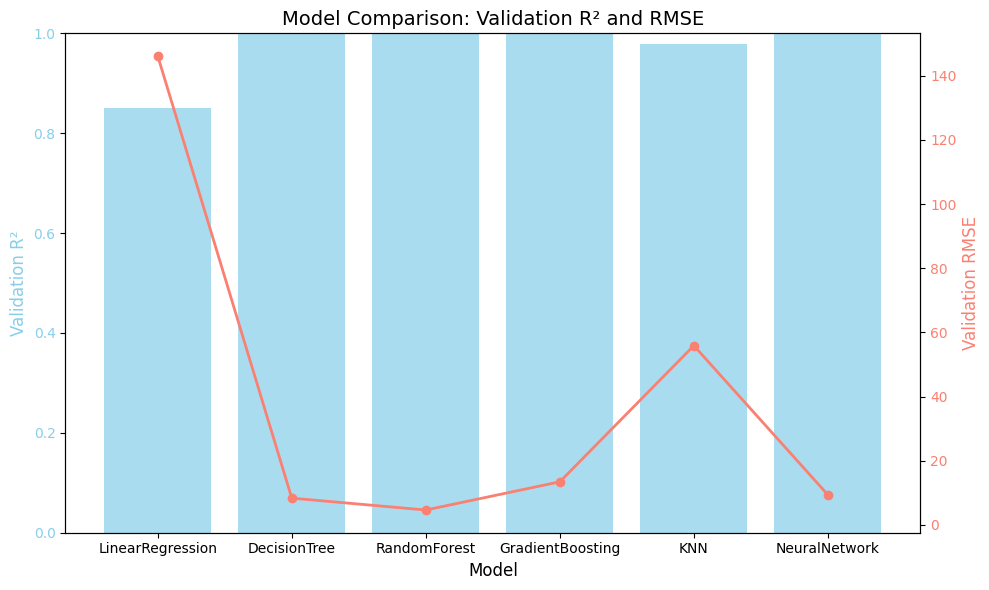

In [29]:
res_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})

fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'skyblue'
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Validation R²', color=color1, fontsize=12)
ax1.bar(res_df['Model'], res_df['R2_val'], color=color1, alpha=0.7, label='Validation R²')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
color2 = 'salmon'
ax2.set_ylabel('Validation RMSE', color=color2, fontsize=12)
ax2.plot(res_df['Model'], res_df['RMSE_val'], color=color2, marker='o', linewidth=2, label='Validation RMSE')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Model Comparison: Validation R² and RMSE", fontsize=14)
fig.tight_layout()
plt.show()


In [30]:

joblib.dump(best_model, os.path.join(ARTIFACTS_DIR, "best_model.pkl"))
joblib.dump(imputer,    os.path.join(ARTIFACTS_DIR, "imputer.pkl"))
joblib.dump(scaler,     os.path.join(ARTIFACTS_DIR, "scaler.pkl"))
joblib.dump(FEATURE_COLS, os.path.join(ARTIFACTS_DIR, "feature_cols.pkl"))
print(f"Saved artifacts to: {ARTIFACTS_DIR}/")

Saved artifacts to: artifacts/


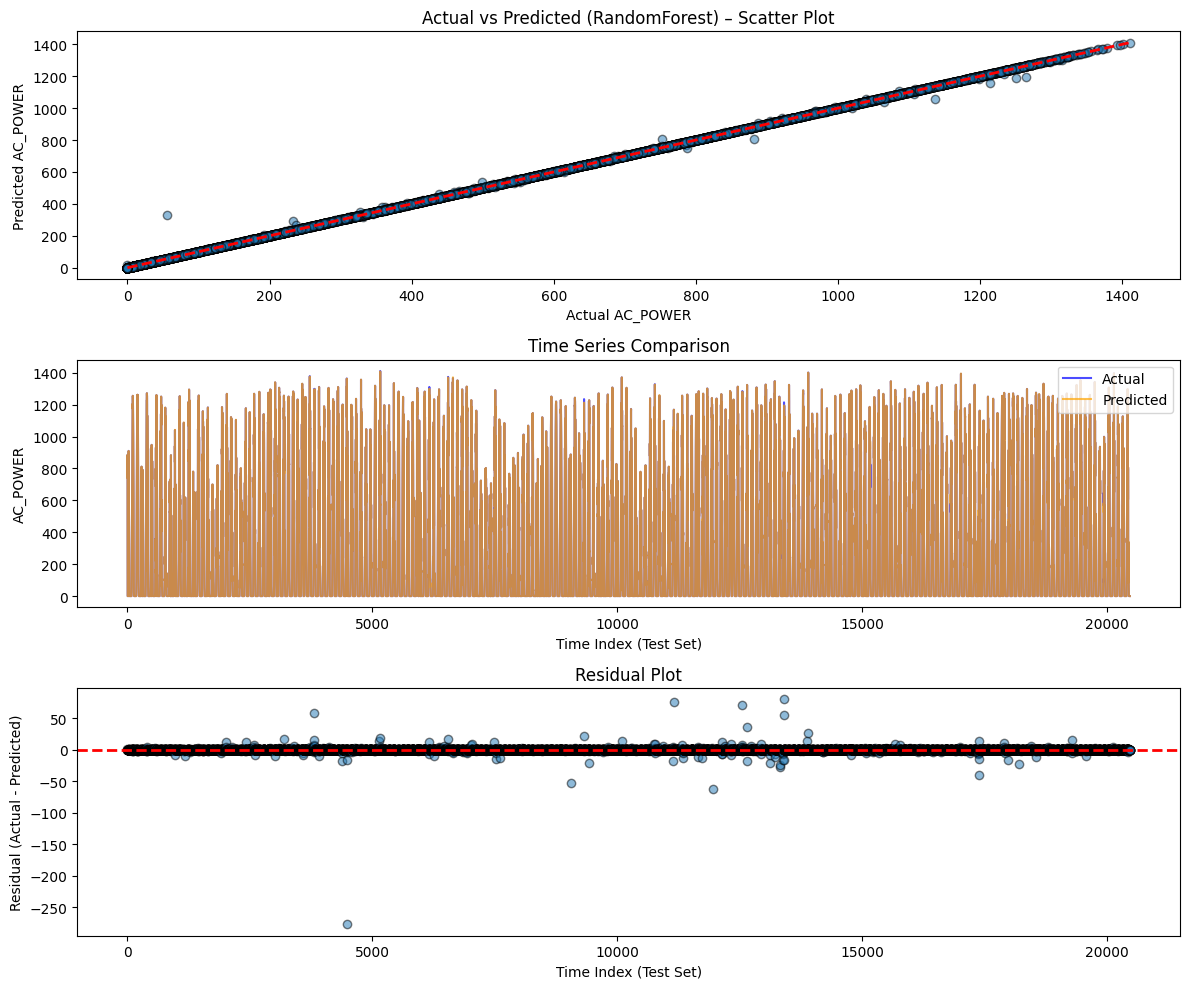

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

pred_test = best_model.predict(X_test_sc)

# Calculate residuals
residuals = y_test.values - pred_test

plt.figure(figsize=(12, 10))

#  Scatter plot (Actual vs Predicted)
plt.subplot(3, 1, 1)
plt.scatter(y_test, pred_test, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual AC_POWER')
plt.ylabel('Predicted AC_POWER')
plt.title(f'Actual vs Predicted ({best_name}) – Scatter Plot')

#  Time series comparison
plt.subplot(3, 1, 2)
plt.plot(y_test.values, label='Actual', color='blue', alpha=0.7)
plt.plot(pred_test, label='Predicted', color='orange', alpha=0.7)
plt.xlabel('Time Index (Test Set)')
plt.ylabel('AC_POWER')
plt.title('Time Series Comparison')
plt.legend()

#  Residual plot
plt.subplot(3, 1, 3)
plt.scatter(range(len(residuals)), residuals, alpha=0.5, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Time Index (Test Set)')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()


In [38]:
HISTORY_PATH = os.path.join(ARTIFACTS_DIR, 'history.csv')

if not os.path.exists(HISTORY_PATH):
    pd.DataFrame(columns=[
        'DATE_TIME','PLANT_ID','SOURCE_KEY','DC_POWER','DAILY_YIELD','TOTAL_YIELD',
        'AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION','AC_POWER'
    ]).to_csv(HISTORY_PATH, index=False)

In [ ]:
def _engineer_stream(df: pd.DataFrame) -> pd.DataFrame:
   

    # Sort by time to maintain sequence
    df = df.sort_values(['SOURCE_KEY', 'DATE_TIME']).copy()

    # Ensure numeric columns are actually numeric
    numeric_cols = [
        'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD',
        'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
        'IRRADIATION', 'AC_POWER'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Create basic time features
    df['HOUR'] = df['DATE_TIME'].dt.hour
    df['DATE'] = df['DATE_TIME'].dt.date

    # Rolling features
    df['DC_POWER_ROLLING_MEAN_1H'] = df.groupby('SOURCE_KEY')['DC_POWER'].transform(lambda x: x.rolling(4, min_periods=1).mean())
    df['DC_POWER_ROLLING_STD_1H']  = df.groupby('SOURCE_KEY')['DC_POWER'].transform(lambda x: x.rolling(4, min_periods=1).std())
    df['IRRADIATION_ROLLING_MAX_3H'] = df.groupby('SOURCE_KEY')['IRRADIATION'].transform(lambda x: x.rolling(12, min_periods=1).max())

    # Lag features
    df['DC_POWER_LAG_1'] = df.groupby('SOURCE_KEY')['DC_POWER'].shift(1)
    df['IRRADIATION_LAG_1'] = df.groupby('SOURCE_KEY')['IRRADIATION'].shift(1)
    if 'USE_AC_LAG' in globals() and USE_AC_LAG:
        df['AC_POWER_LAG_1'] = df.groupby('SOURCE_KEY')['AC_POWER'].shift(1)

    # Cumulative daily yield
    df['DAILY_YIELD_CUMSUM'] = df.groupby(['SOURCE_KEY', 'DATE'])['DAILY_YIELD'].cumsum()

    # Interaction feature
    df['IRRADIATION_x_AMBIENT_TEMP'] = df['IRRADIATION'] * df['AMBIENT_TEMPERATURE']

    # Efficiency
    eps = 1e-6
    df['EFFICIENCY'] = df['DC_POWER'] / (df['IRRADIATION'] + eps)

    return df


In [42]:
def predict_ac_power_raw(plant_id:int, source_key:str, timestamp:str,
                         dc_power:float, daily_yield:float, total_yield:float,
                         ambient_temp:float, module_temp:float, irradiation:float,
                         use_neural: bool = False) -> float:
    """Predict AC power for a single new reading. Maintains history for rolling/lag features."""
    
    # Load model + preprocessing artifacts
    model_path = os.path.join(ARTIFACTS_DIR, 'neural_model.pkl' if use_neural else 'best_model.pkl')
    model  = joblib.load(model_path)
    imp    = joblib.load(os.path.join(ARTIFACTS_DIR, 'imputer.pkl'))
    scl    = joblib.load(os.path.join(ARTIFACTS_DIR, 'scaler.pkl'))
    feats  = joblib.load(os.path.join(ARTIFACTS_DIR, 'feature_cols.pkl'))

    # Load history and append new row
    hist = pd.read_csv(HISTORY_PATH)
    hist['DATE_TIME'] = pd.to_datetime(hist['DATE_TIME'], errors='coerce')

    new = pd.DataFrame([{
        'DATE_TIME': pd.to_datetime(timestamp),
        'PLANT_ID': plant_id,
        'SOURCE_KEY': source_key,
        'DC_POWER': dc_power,
        'DAILY_YIELD': daily_yield,
        'TOTAL_YIELD': total_yield,
        'AMBIENT_TEMPERATURE': ambient_temp,
        'MODULE_TEMPERATURE': module_temp,
        'IRRADIATION': irradiation,
        'AC_POWER': np.nan
    }])

    combo = pd.concat([hist, new], ignore_index=True)
    combo = _engineer_stream(combo)

    # Prepare latest features
    latest = combo.iloc[[-1]][feats]
    latest_imp = imp.transform(latest)
    latest_sc  = scl.transform(latest_imp)
    pred = float(model.predict(latest_sc)[0])

    # Save updated history
    combo = combo[list(hist.columns)]
    combo.to_csv(HISTORY_PATH, index=False)

    return pred


In [45]:
def forecast_future(future_df: pd.DataFrame, use_neural: bool = False) -> pd.DataFrame:
    """future_df must contain: DATE_TIME, PLANT_ID, SOURCE_KEY, DC_POWER, DAILY_YIELD, TOTAL_YIELD, AMBIENT_TEMPERATURE, MODULE_TEMPERATURE, IRRADIATION"""
    model_path = os.path.join(ARTIFACTS_DIR, 'neural_model.pkl' if use_neural else 'best_model.pkl')
    model  = joblib.load(model_path)
    imp    = joblib.load(os.path.join(ARTIFACTS_DIR, 'imputer.pkl'))
    scl    = joblib.load(os.path.join(ARTIFACTS_DIR, 'scaler.pkl'))
    feats  = joblib.load(os.path.join(ARTIFACTS_DIR, 'feature_cols.pkl'))

    hist = pd.read_csv(HISTORY_PATH)
    hist['DATE_TIME'] = pd.to_datetime(hist['DATE_TIME'], errors='coerce')

    fut = future_df.copy()
    fut['DATE_TIME'] = pd.to_datetime(fut['DATE_TIME'], errors='coerce')

    combo = pd.concat([hist, fut], ignore_index=True)
    combo = _engineer_stream(combo)

    ask = combo[combo['DATE_TIME'].isin(fut['DATE_TIME'])][feats]
    ask_imp = imp.transform(ask)
    ask_sc  = scl.transform(ask_imp)
    preds = model.predict(ask_sc)

    out = fut[['DATE_TIME']].copy()
    out['PRED_AC_POWER'] = preds
    return out
USE_AC_LAG = True



In [48]:
pred_now = predict_ac_power_raw(
    plant_id=1,
    source_key='INV_01',
    timestamp='2025-08-14 14:00:00',
    dc_power=520,
    daily_yield=45,
    total_yield=2100,
    ambient_temp=26,
    module_temp=32,
    irradiation=780
)

print('Realtime prediction:', pred_now)

Realtime prediction: 509.3710158730158


In [49]:
fut = pd.DataFrame({
    'DATE_TIME': pd.date_range('2025-08-15 06:00', periods=12, freq='H'),
    'PLANT_ID': 1,
    'SOURCE_KEY': 'INV_01',
    'DC_POWER': np.linspace(100, 900, 12),
    'DAILY_YIELD': np.linspace(0, 120, 12),
    'TOTAL_YIELD': 2500 + np.linspace(0, 120, 12),
    'AMBIENT_TEMPERATURE': np.linspace(22, 32, 12),
    'MODULE_TEMPERATURE': np.linspace(25, 40, 12),
    'IRRADIATION': np.linspace(50, 900, 12)
})

fut_pred = forecast_future(fut)
print(fut_pred.head())


            DATE_TIME  PRED_AC_POWER
0 2025-08-15 06:00:00      97.281329
1 2025-08-15 07:00:00     169.745752
2 2025-08-15 08:00:00     240.676973
3 2025-08-15 09:00:00     311.620168
4 2025-08-15 10:00:00     383.000805
